In [28]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel
from dowhy.causal_graph import CausalGraph
from dowhy.causal_estimators.econml import Econml

from dowhy.causal_identifier import (
    BackdoorAdjustment,
    EstimandType,
    identify_effect,
    identify_effect_auto,
    identify_effect_id,
)

from econml.metalearners import SLearnerearner

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [2]:
dowhy.__version__

'0.9'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 10



## S-Learner: The Lone Ranger

In [6]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

### Read the data

In [7]:
# Train set
earnings_interaction_train = pd.read_csv(r'./data/ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv(r'./data/ml_earnings_interaction_test.csv')

In [8]:
earnings_interaction_train.shape, earnings_interaction_test.shape

In [9]:
# Train 
earnings_interaction_train.head()

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0
3,25,0.945161,False,130291.0
4,30,0.636251,True,164209.0


In [10]:
# Test
earnings_interaction_test.head()

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0
3,21,0.869069,True,14345.0
4,41,0.833934,True,14169.0


### Define the graph

In [11]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

# >>NEW API<<

In [20]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

graph = CausalGraph(
    treatment_name='took_a_course',
    outcome_name='earnings',
    graph=gml_string,
    effect_modifier_names='python_proficiency',
#     common_cause_names=data["common_causes_names"],
    observed_node_names=nodes,
)

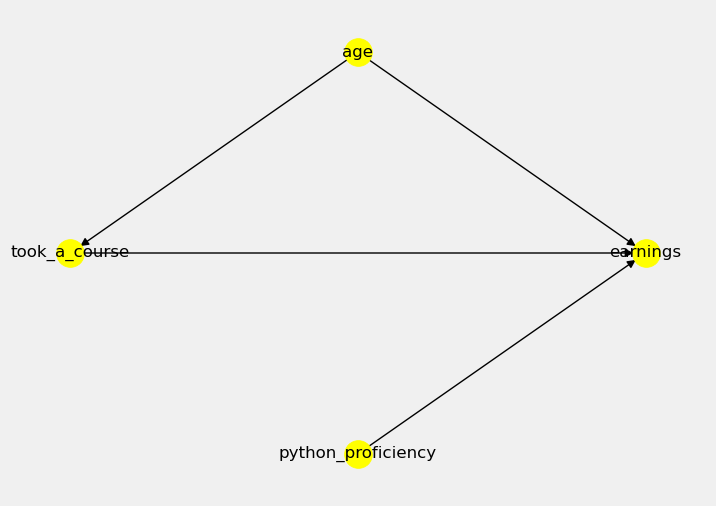

In [22]:
graph.view_graph()

### Get the estimand

In [36]:
# Get the estimand
identified_estimand = identify_effect(
    graph=graph, 
    treatment_name='took_a_course', 
    outcome_name='earnings')

# # auto_identify_effect example with extra parameters:
# identified_estimand_auto = identify_effect_auto(
#     graph,
#     treatment_name,
#     outcome_name,
#     estimand_type=EstimandType.NONPARAMETRIC_ATE,
#     backdoor_adjustment=BackdoorAdjustment.BACKDOOR_EFFICIENT,
# )

# # id_identify_effect example:
# identified_estimand_id = identify_effect_id(
#     graph, treatment_name, outcome_name
# )  # Note that the return type for id_identify_effect is IDExpression and not IdentifiedEstimand

# print(identified_estimand)

### Estimate the effect

In [42]:
estimator = Econml(
    identified_estimand=identified_estimand,
    econml_estimator=SLearner(
        overall_model=LGBMRegressor(n_estimators=500, max_depth=10),
    ),
).fit(
    data=earnings_interaction_train,
    treatment_name=['took_a_course'],
    outcome_name=['earnings'],
    effect_modifier_names=graph.get_effect_modifiers(
        nodes1=['took_a_course'], 
        nodes2=['earnings']),
)

estimate_econml = estimator.estimate_effect(
    data=earnings_interaction_train,
    target_units='ate',
)

print(estimate_econml)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

## Realized estimand
b: earnings~took_a_course+python_proficiency+age
Target units: ate

## Estimate
Mean value: 12547.068205674783
Effect estimates: [[12656.36520543]
 [14362.76895365]
 [11965.20495174]
 ...
 [13812.20928872]
 [12930.34061036]
 [13863.00226379]]



Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [63]:
est_test = estimator.effect(df=earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

## >>NEW API RESULTS ON TEST<<

In [69]:
mean_absolute_percentage_error(
    earnings_interaction_test['true_effect'], 
    est_test)

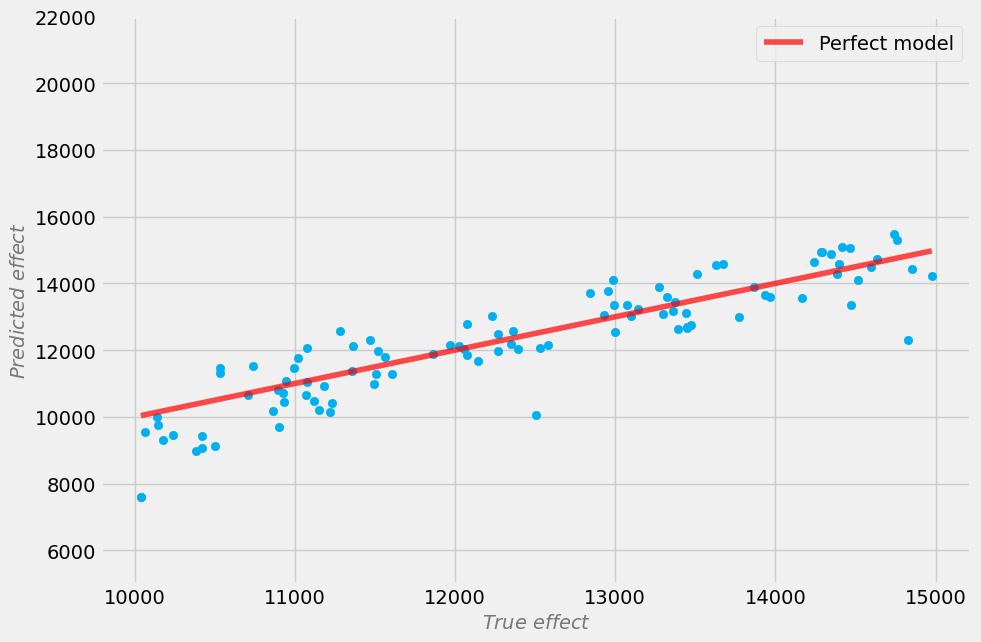

In [67]:
plot_effect(
    effect_true=earnings_interaction_test['true_effect'],
    effect_pred=est_test
)

# >>OLD API<<

In [57]:
# Get estimate (S-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(n_estimators=500, max_depth=10)
        },
        'fit_params': {}
    })

C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [58]:
estimate.cate_estimates.mean()

### Predict on test data

In [59]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

## >>OLD API RESULTS ON TEST<<

In [60]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

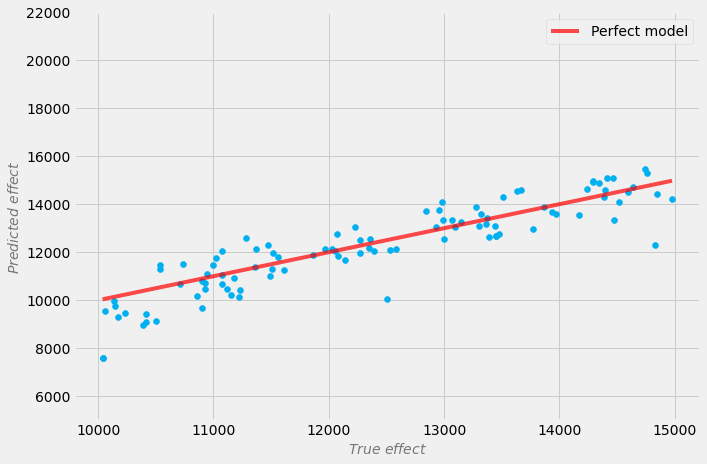

In [114]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)